The number of timesteps is 98


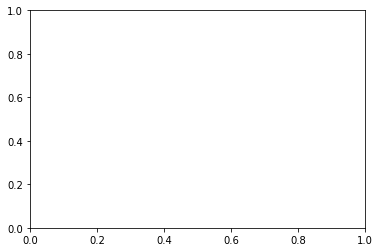

In [44]:
import pdb
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb
import scipy
from scipy.optimize import minimize, rosen, rosen_der


%matplotlib inline

DATA_FILE = "exportUSLab.csv" # Points to the data Katie gave us
VISUALIZE = False
ALARM_THRESHOLD = 2e-20
BIG_NUMBER = 100

all_points = [[]] # This is a doubly-nested list with each internal list representing a single timestep

with open(DATA_FILE, 'r') as infile: # read through line by line and parse by the time
    for line in infile:
        if "symmetry" in line:
            all_points.append([line])
        all_points[-1].append(line)  
       
print("The number of timesteps is {}".format(len(all_points)))

plt.cla()

all_times = []
max_consentrations = []
for time in all_points[1:-1]: #only do a few at the end for speed reasons
    df = pd.read_csv(io.StringIO('\n'.join(time[4:])))#
    df = df.rename(columns={'Node Number': 'N',
                  ' X [ m ]' : 'X',
                  ' Y [ m ]' : 'Y',
                  ' Z [ m ]' : 'Z',
                  ' Particle Mass Concentration [ kg m^-3 ]' : 'C'})
    all_times.append(df)
    consentration = df['C'].values[0:-1] # get all of the consentrations but the null last one
    max_consentrations.append(np.max(consentration))

if VISUALIZE:
    print(max_consentrations)
    max_consentration = max(max_consentrations)
    print(max_consentration)
    
    for i, df in enumerate(all_times): 
    
        plt.cla()
        plt.clf()
        plt.xlabel("X position")
        plt.ylabel("Y position")
        plt.title("consentration at timestep {} versus position".format(i))
        norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
        cb = plt.scatter(df['X'], df['Y'], c=df['C'] / max_consentration, cmap=plt.cm.inferno, norm=norm)
        plt.colorbar(cb) # Add a colorbar to a plot
        plt.savefig("vis/consentration{:03d}.png".format(i))

So the next thing we want to do is convert the output to a 2d space

There are 96 timesteps and 2666 flattened locations


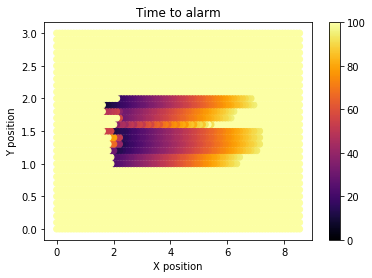

In [48]:
consentrations = np.asarray([x['C'].values[:-1] for x in all_times]) # Get all of the consentrations 
print("There are {} timesteps and {} flattened locations".format(consentrations.shape[0], consentrations.shape[1])) 

alarmed = consentrations > 2 * ALARM_THRESHOLD
nonzero = np.nonzero(alarmed)
nonzero_times, nonzero_locations = nonzero # this is pairs indicating that it alarmed at that time and location

time_to_alarm = []
for loc in range(alarmed.shape[1] + 1): # All of the possible locations
    same = loc == nonzero_locations
    if(np.any(same)):
        alarmed_times = nonzero_times[same]
        #print("alarmed times {} at location {}".format(alarmed_times, loc))
        #print("first alarmed times is {} at location {}".format(min(alarmed_times), loc))
        time_to_alarm.append(min(alarmed_times))
    else:
        time_to_alarm.append(BIG_NUMBER)
        

#print(time_to_alarm)

plt.cla()
plt.clf()
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Time to alarm")
norm = mpl.colors.Normalize(vmin=0, vmax=BIG_NUMBER)
cb = plt.scatter(df['X'], df['Y'], c=time_to_alarm, cmap=plt.cm.inferno, norm=norm)
plt.colorbar(cb) # Add a colorbar to a plot

In [49]:
#
#from scipy import interpolate
def make_lookup(X, Y, time_to_alarm):
    """Returns a function which searches 
    the data at the sample nearest a given point
    """
    best = np.argmin(time_to_alarm) # get the location of the shortest time to alarm
    XY = np.vstack((X,Y)).transpose() # combine the x and y data points
    print("The best time is {} and occurs at {}".format(time_to_alarm[best], XY[best,:]))
    EPSILON = 0.00000001
    def ret_func(xy): # this is what will be returned
        diff = xy - XY # get the x and y distances from the query point for each marked point
        dist = np.linalg.norm(diff, axis=1)
        locs = np.argsort(dist)[:4]
        weights = 1.0 / (dist[locs] + EPSILON) # weight by one over the distance to the sample point
        reweighted = weights * time_to_alarm[locs]
        closest_time = sum(reweighted) / sum(weights)
        #f = interpolate.interp2d(X, Y, time_to_alarm)
        return closest_time
    return ret_func

ret_func = make_lookup(df["X"][:-1], df["Y"][:-1], np.array(time_to_alarm[:-1]))
BEST_LOC = np.array([2.31082344, 1.70000005])
BAD_LOC = np.array([2, 2])

print("The best value is {}".format(ret_func(BEST_LOC)))
print("A bad value is {}".format(ret_func(BAD_LOC)))

The best time is 10 and occurs at [1.70799994 1.89999998]
The best value is 32.00000388828962
A bad value is 93.75677932790752


In [50]:

BOUNDS = ((0,8),(0, 3)) # constraints on inputs
INIT = (4,1.5)
res = minimize(ret_func, INIT, method='SLSQP', bounds=BOUNDS)
print(res)


     fun: 19.487542415524576
     jac: array([12.40295005, -3.91262627])
 message: 'Optimization terminated successfully.'
    nfev: 189
     nit: 32
    njev: 31
  status: 0
 success: True
       x: array([2.33386624, 1.98633711])
